In [1]:
import os
import cv2
import skimage

import numpy as np
import sklearn
import pandas as pd  
import tensorflow as tf

from keras.models import load_model
from mtcnn import MTCNN
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
from face_embedding import face_embedding
from face_detection import face_cropping, l2_normalize
from save_file import save_data

In [16]:
sklearn.__version__

'1.0.2'

In [17]:
image_train_path = '../data/faces/train/'
image_test_path = '../data/faces/test/'
# path to extract the names of the dictionary : repo name = celebrity name
image_dir_path = '../data/faces/train/'

names = [ name for name in os.listdir(image_dir_path) if os.path.isdir(os.path.join(image_train_path, name)) ]
print(names)

['BOUCHET, RAPHAELE', 'LOEW, JOACHIM', 'CONFINO, BASTIEN', 'CLIVAZ, FLORIAN', 'FISCHER, PATRICK (HOCKEYEUR)', 'DE WECK, GABRIEL', 'LAGRANGE, JEAN-JACQUES', 'OZIL, MESUT', 'ZISYADIS, ABRAHAM', 'BALE, GARETH']


In [6]:
# deep face 
#model_path = '../data/models/deepface/keras/deepface_fn_512.h5'
#model_path = '../data/models/deepface/keras/deepface_fn_128.h5'

# face net
#model_path = '../data/models/facenet/keras/facenet_ds_keras_128.h5'
model_path = '../data/models/facenet/keras/facenet_ds_keras_512.h5'

model_emb = load_model(model_path, compile = False , custom_objects={"tf": tf})


/Users/aro/.local/share/virtualenvs/benchmark-face-reco-22Dl5Lw1/lib/python3.9/site-packages/keras/layers/core/lambda_layer.py:303: UserWarning: FaceNet is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,
2022-04-20 11:31:47.025687: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# Save files : crop faces and metadata
path_arrays = "../data/arrays/"
array_name = "embeddings_celeb"
file_emb_celeb_np = path_arrays + array_name + '.npy'
file_metadata_json = path_arrays + array_name + '.json'

# Hyperparamters for cropping

# Contour margin for the face cropping
margin = 0
# mininum size of the face
min_face_size = 20
image_size = 160

metadata_celeb = {
                  'filename_metadata': file_metadata_json,
                  'filename_embeddings': file_emb_celeb_np,
                  'face_detection' : 'MTCNN',
                  'model_emb': 'facenet_ds_keras_512.h5',
                  'crop_margin': margin,
                  'min_face_size': min_face_size,
                  'image_size' : image_size,
                  }



In [8]:
# MTCNN model
face_detector = MTCNN(min_face_size=min_face_size)

# faces
faces_emb = []
label = []
uuid_faces = []

for idx, name in enumerate(names):

    name_dir = image_dir_path + name
    image_filepaths = [os.path.join(name_dir, f)
                       for f in os.listdir(name_dir)]

    for iname, image in enumerate(image_filepaths):

        # for videos : image_np = frame_np
        image_np = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
        
        face_crop = face_cropping(image_np, face_detector,
                                  max_nb_faces=10000,
                                  margin=margin,
                                  image_size=image_size,
                                  flag_normalise=False,
                                  flag_plot=False)
        if face_crop.size > 0:
            face_emb = face_embedding(model_emb, face_crop)

        faces_emb.append(face_emb)

        for k in range(np.shape(face_emb)[0]):
            label.append(name)

faces_emb_celeb_np = np.concatenate(faces_emb, axis=0)
label_emb_celeb_np = np.array(label)

In [9]:
np.shape(faces_emb_celeb_np)

(200, 512)

In [10]:
# instantiate the tsne 
tsne = TSNE(n_iter=1500, n_components=2, perplexity=10)

In [11]:
embs_tsne = tsne.fit_transform(faces_emb_celeb_np)

/Users/aro/.local/share/virtualenvs/benchmark-face-reco-22Dl5Lw1/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/aro/.local/share/virtualenvs/benchmark-face-reco-22Dl5Lw1/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


# Visualisation of the embeddings space 

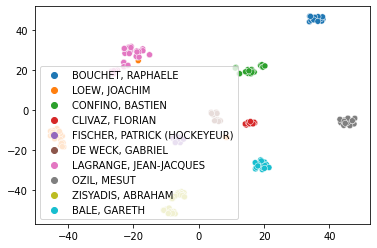

In [12]:
import mpld3
mpld3.enable_notebook()

x = embs_tsne[:, 0]
y = embs_tsne[:, 1]

fig, ax = plt.subplots()
sns.scatterplot(x=x, y=y, hue=label_emb_celeb_np)
plt.show()

In [13]:
faces_emb_np = np.concatenate(faces_emb_celeb_np, axis=0)

In [14]:
save_data(file_emb_celeb_np, faces_emb_np, file_metadata_json, metadata_celeb)